In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

In [57]:
# FUNCTIONS
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    phi_quad = 360/N
    phase = phi_quad*n*n/2
    phase = phase%360
 
    #in degree
    return phase



In [58]:
for n in range(0,19):
    print(QuadraticPhase(3, n))

0.0
60.0
240.0
180.0
240.0
60.0
0.0
60.0
240.0
180.0
240.0
60.0
0.0
60.0
240.0
180.0
240.0
60.0
0.0


In [61]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
TR = 2e-3 
TE = TR/2
# tip angle alpha 10, 30, 90 degree
tip_angle = 10
#phase cycling
Period = 3
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)

off_res_max = 1/TR
off_res = np.linspace(-off_res_max, off_res_max, 500+1)
off_res = off_res[0:-1]

In [67]:

#----------------------------------------------------------------------------------------------
#repeated period in the off-resonance profile

#store value
off_resonance_f = np.asarray([], dtype = int)
M_complex_steady = np.asarray([], dtype = float)
M_complex_steady_2 = np.asarray([], dtype = float)
M_complex_steady_3 = np.asarray([], dtype = float)
M_complex_steady_4 = np.asarray([], dtype = float)

#Find steady state value for different off-resonance 
#f_off = 200 is next period, so here we only use -200~199
for f_off in off_res:
    M_pre = M0 #initial pre pulse magnetisation 
    #templorary store value
    M_complex = np.asarray([], dtype = float)
    phase_shift = 0
    Period_num = 0

    #repeat 1000 times for each off-resonance frequency
    for k in range(1,500):
        #Calculate phase shift (degree) for this TR
        phase_shift = QuadraticPhase(Period, Period_num)
        #Tip
        M_post = RF_pulse(tip_angle,phase_shift) @ M_pre

        #Consider T1 recovery, T2 decay and precession
        #@ time TE 
        P_TE = Precession(f_off,TE) #precession matrix at t = TE
        E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

        M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
        

        #@ time TR 
        P_TR = Precession(f_off,TR) #precession matrix at t = TR
        E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
        M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
        M_pre = M_TR

        #store the transverse magnetisation in complex form, Mx+iMy
        M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))#*np.exp(-1j*phase_shift/180*np.pi))

        Period_num = Period_num + 1


    #END
    #take the final steady signal, store the transverse steady state signal for different off-resonance frequency
    M_complex_steady = np.append(M_complex_steady, M_complex[-1])
    M_complex_steady_2 = np.append(M_complex_steady_2, M_complex[-2])
    M_complex_steady_3 = np.append(M_complex_steady_3, M_complex[-3])
    M_complex_steady_4 = np.append(M_complex_steady_4, M_complex[-4])
    off_resonance_f = np.append(off_resonance_f, f_off)


#END
#Fourier transform of the off-resonance profile --> contribution from each F-state
S_F = np.fft.fft(M_complex_steady)
S_F = np.absolute(S_F)
S_F = np.fft.fftshift(S_F)

F_state = np.fft.fftfreq(M_complex_steady.shape[-1], d = 1.0)
F_state = np.fft.fftshift(F_state)*M_complex_steady.shape[-1]


Text(0.5, 1.0, 'Fstate of 3 period')

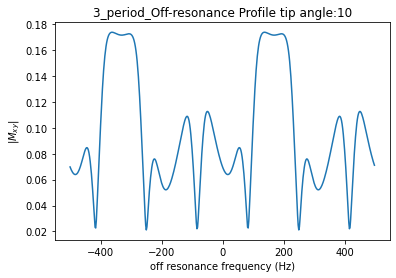

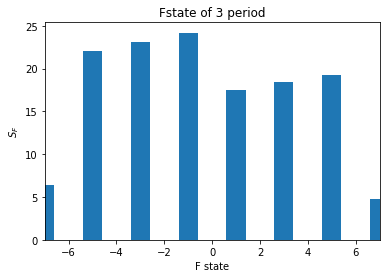

In [68]:
#plot M_xy at steady state against off-resonance frequency
plt.figure(1)
plt.plot(off_resonance_f, np.absolute(M_complex_steady))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))    


plt.figure(2)
plt.xlim([-7,7])
plt.bar(F_state, S_F)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")


Text(0.5, 1.0, 'Fstate of 3 period')

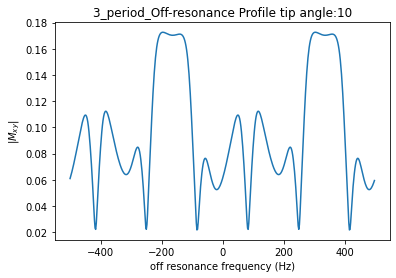

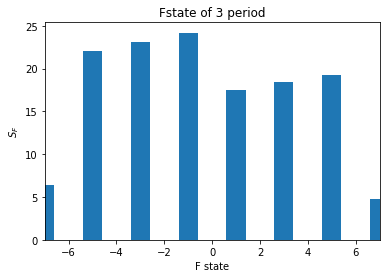

In [64]:
#plot M_xy at steady state against off-resonance frequency
plt.figure(1)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_2))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))    


plt.figure(2)
plt.xlim([-7,7])
plt.bar(F_state, S_F)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")


Text(0.5, 1.0, 'Fstate of 3 period')

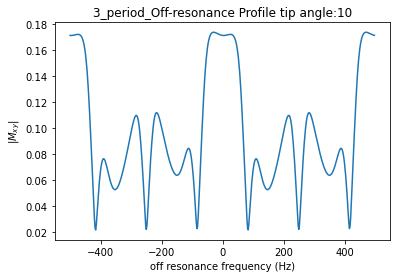

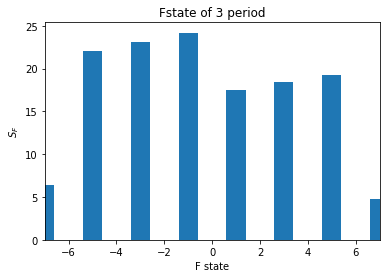

In [65]:
#plot M_xy at steady state against off-resonance frequency
plt.figure(1)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_3))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))    


plt.figure(2)
plt.xlim([-7,7])
plt.bar(F_state, S_F)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")


Text(0.5, 1.0, 'Fstate of 4 period')

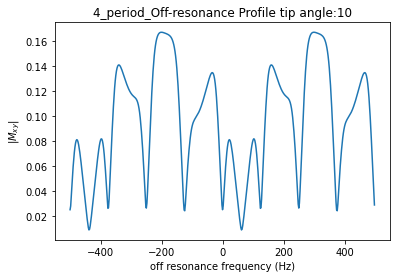

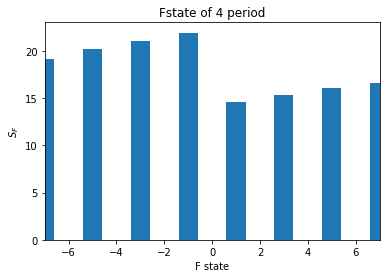

In [53]:
#plot M_xy at steady state against off-resonance frequency
plt.figure(1)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_4))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))    


plt.figure(2)
plt.xlim([-7,7])
plt.bar(F_state, S_F)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")


In [34]:
phase = np.exp(1j*np.linspace(-np.pi,np.pi,501))
phase = phase[0:-1]
M_transverse_new = np.transpose(M_complex_steady_4)*phase.reshape(1,500)
S_F = np.fft.fft(M_transverse_new)
S_F = np.absolute(S_F)
S_F = np.fft.fftshift(S_F)

F_state = np.fft.fftfreq(M_complex_steady.shape[-1], d = 1.0)
F_state = np.fft.fftshift(F_state)*M_complex_steady.shape[-1]


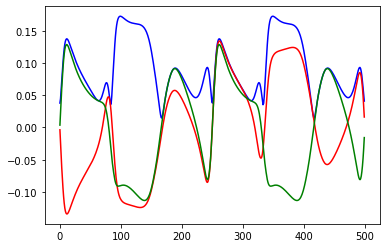

In [33]:
plt.plot(np.abs(M_complex_steady_4),'b')
plt.plot(np.real(M_complex_steady_4),'r')
plt.plot(np.real(M_transverse_new[0,:]),'g')

(200.0, 300.0)

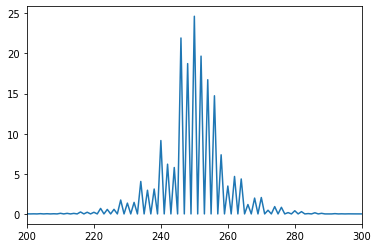

In [37]:
plt.plot(S_F[0,:])
plt.xlim(200,300)